Overlay scores on heatmaps

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image
import matplotlib.pyplot as plt

In [260]:
results_dir = "image_sets/results_2/exp_10_s1/"

Plotly overlay

In [261]:
import plotly.figure_factory as ff

plt.text overlay

In [262]:
patch_folder = "image_sets/patches/F005a02/"

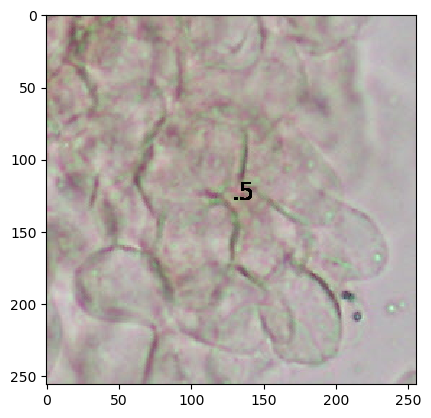

In [263]:
for patch_file in sorted(os.listdir(patch_folder)):
    img_path = os.path.join(patch_folder, patch_file)
    img = Image.open(img_path)
    plt.text(128, 128, r'.5',fontsize='xx-large')
    plt.imshow(img)

Check .pt files shape

In [6]:
import torch

In [15]:
filePath = "experiments/features/resnet50_overlap_test/F005a02.pt"
a = torch.load(filePath)

In [16]:
print(a.shape)

torch.Size([77, 6, 1, 1, 1024])


patch annotations

In [45]:
import os
import argparse
import yaml
import cv2
import numpy as np
from PIL import Image
from itertools import product
import matplotlib.pyplot as plt

from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image

In [60]:
filename = "F030a11.tif"
dir_in = "image_sets/original/"
patch_dir = "image_sets/patches_annotated/"
threshold = 35
d = 256 # patch size

[771, 300, 837, 10872, 4017, 1158, 816, 297, 363, 366, 951, 357, 2043, 1173, 2574, 1725, 2034, 1002, 3693, 3624, 4239, 2469, 3948, 3144]


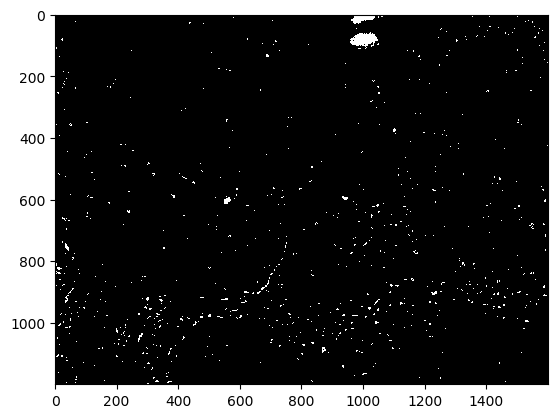

In [61]:
patch_scores = []
name, ext = os.path.splitext(filename)
dir_out = os.path.join(patch_dir, name)
img_cv = cv2.imread(os.path.join(dir_in, filename))
img_cv_gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
ret, img_cv_binarized = cv2.threshold(img_cv_gray, threshold, 255, cv2.THRESH_BINARY_INV)  # Apply thresholding
img_pil_binarized = cv2.cvtColor(img_cv_binarized, cv2.COLOR_BGR2RGB)  # Convert to RGB, for PIL Image
img_pil_binarized = Image.fromarray(img_pil_binarized)  # Convert to PIL Image
w, h = img_pil_binarized.size

grid = product(range(0, h-h%d, d), range(0, w-w%d, d))
for i, j in grid:
    box = (j, i, j+d, i+d)
    i /= 256
    j /= 256
    out = os.path.join(dir_out, f'{name}_{int(i)}_{int(j)}{ext}')

    img_patch = img_pil_binarized.crop(box)

    img_patch_np = np.asarray(img_patch)  # Convert to Numpy array
    patch_non_zero = np.count_nonzero(img_patch_np)
    patch_scores.append(patch_non_zero)

    # img_patch.save(out)  # Save patch image    

plt.imshow(img_pil_binarized)
print(patch_scores)

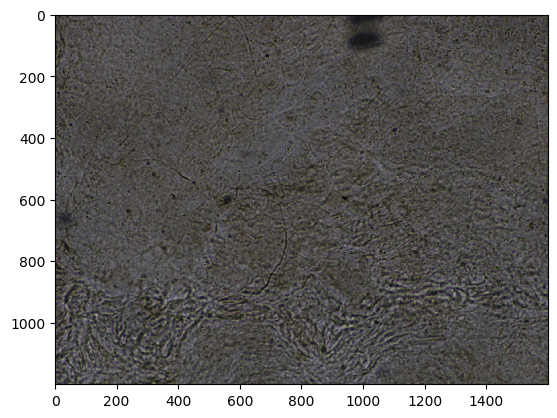

In [62]:
plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))

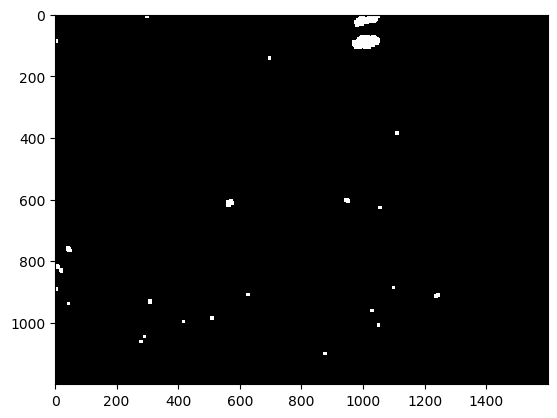

In [63]:
kernel = np.ones((2, 2), np.uint8)
img_cv_eroded = cv2.erode(img_cv_binarized.copy(), kernel, iterations=5)
img_cv_dilated = cv2.dilate(img_cv_eroded.copy(), kernel, iterations=10)
img_cv_dilated = cv2.cvtColor(img_cv_dilated, cv2.COLOR_BGR2RGB)
plt.imshow(img_cv_dilated, cmap='gray')

In [64]:
# cv2.blur(img_cv_eroded, ())

In [51]:
print(img_cv_dilated.shape)
print(img_cv_gray.shape)

(1200, 1600, 3)
(1200, 1600)


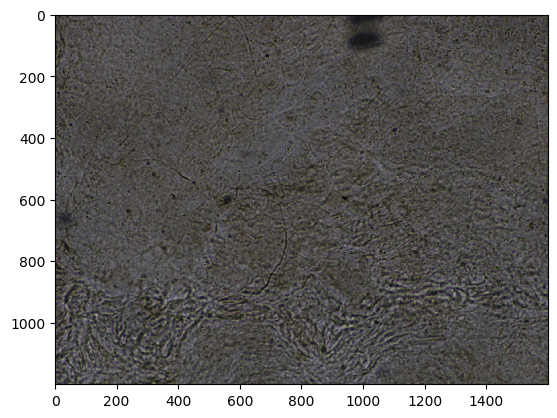

In [52]:
# new = cv2.addWeighted(img_cv_gray, 1, img_cv_eroded, 2, 0)
new = cv2.add(img_cv, img_cv_dilated)
plt.imshow(cv2.cvtColor(new, cv2.COLOR_BGR2RGB))

Patch threshold

In [5]:
import os
import argparse
import yaml
import cv2
import numpy as np
from PIL import Image
from itertools import product
import matplotlib.pyplot as plt
from utils.file_utils import save_pkl, load_pkl

from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image

In [17]:
filename = "F005a02.tif"
dir_in = "image_sets/annotated/"
patch_dir = "image_sets/patches_annotated/"
threshold = 2500
d = 256 # patch size

In [18]:
name, ext = os.path.splitext(filename)
dir_out = os.path.join(patch_dir, name)

In [19]:
img_scores = load_pkl(os.path.join(dir_out, name+".pkl"))
print(img_scores)

{'patch_scores': [7032, 10353, 7677, 3762, 5256, 0, 279, 3897, 13623, 2697, 1800, 0, 0, 3981, 5706, 7824, 90, 0, 7494, 4839, 4695, 1200, 0, 0], 'bin_scores': [False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]}


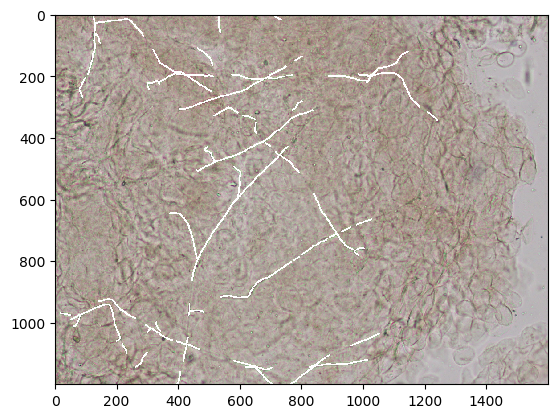

In [20]:
orig_img = Image.open(os.path.join(dir_in, filename))
plt.imshow(orig_img)

Annot splits

In [29]:
import random
random.seed(1)

In [30]:
a = ['N001a001', 'N001a002', 'N003a001', 'N003a002', 'N004a005', 'N004a006', 'N004a008', 'N004a009', 'N004a010', 'N004a011', 'N004a013', 'N004a017', 'N004a018', 'N004a020', 'N004a021', 'N004a022', 'N004a023', 'N004a024', 'N004a025', 'N004a026', 'N004a028', 'N004a032', 'N004a036', 'N004a037', 'N004a038', 'N004a039', 'N004a041', 'N004a042', 'N004a043', 'N004a044', 'N004a045', 'N004a046', 'N004a048', 'N004a049', 'N004a050', 'N004a051', 'N004a052', 'N004a053', 'N004a054', 'N004a059', 'N004a060', 'N004a061', 'N004a062', 'N004a064', 'N004a066', 'N004a067', 'N004a068', 'N004a071', 'N004a072', 'N004a073', 'N004a074', 'N004a075', 'N004a076', 'N004a077', 'N004a078', 'N004a079', 'N004a081', 'N004a082', 'N004a083', 'N004a084', 'N004a085', 'N004a087', 'N004a088', 'N004a091', 'N004a092', 'N004a094', 'N004a095', 'N004a096', 'N004a097', 'N004a098', 'N004a099', 'N004a100', 'N004a101', 'N004a105', 'N004a106', 'N004a109', 'N004a110', 'N004a111', 'N004a112', 'N004a113', 'N004a115', 'N004a116', 'N004a117', 'N004a120', 'N004a121', 'N004a123', 'N004a124', 'N004a125', 'N004a127', 'N004a128', 'N004a129', 'N004a130', 'N004a131', 'N004a132', 'N004a133', 'N004a134', 'N004a135', 'N004a136', 'N005a001', 'N005a002', 'N005a003', 'N005a005', 'N005a006', 'N005a007', 'N005a009', 'N005a012', 'N005a013', 'N005a015', 'N005a016', 'N005a018', 'N005a019', 'N005a021', 'N005a022', 'N005a023', 'N006a001', 'N006a002', 'N006a004', 'N006a005', 'N006a007', 'N006a008', 'N006a009', 'N006a010', 'N007a001', 'N007a002', 'N007a003', 'N007a004', 'N009a001', 'N009a002', 'N009a005', 'N009a006', 'N011a001', 'N011a002', 'N011a003', 'N011a005', 'N011a006', 'N011a007', 'N011a008', 'N011a009', 'N011a010', 'N012a002', 'N012a003', 'N012a004', 'N012a008', 'N012a009', 'N012a010', 'N012a013', 'N012a016', 'N012a017', 'N012a019', 'N012a020', 'N017a001', 'F005a02', 'F006a01', 'F030a13', 'F030a14', 'F030a15', 'F030a17', 'F033a01','F033a02', 'F033a03', 'F033a04', 'F033a07', 'F033a09', 'F033a10', 'F033a11', 'F033a12', 'F033a15', 'F033a19', 'F033a20', 'F033a22', 'F033a23', 'F033a24', 'F033a25', 'F033a26', 'F033a27', 'F033a28', 'F033a29', 'F034a05', 'F034a06', 'F034a08', 'F034a09', 'F034a10', 'F034a11', 'F007a04', 'F048a02', 'F050a01', 'F050a03', 'F052a01', 'F052a03', 'F052a04', 'F052a05', 'F007a05', 'F052a06', 'F052a09', 'F052a10', 'F052a11', 'F052a12', 'F007a06', 'F052a16', 'F052a17', 'F052a18', 'F052a19', 'F052a20', 'F053a01', 'F053a02', 'F053a03', 'F053a04', 'F053a06', 'F053a07', 'F053a09', 'F053a10', 'F053a11', 'F053a12', 'F053a13', 'F053a14', 'F053a16', 'F053a18', 'F056a01', 'F056a05', 'F056a06', 'F056a07', 'F056a08', 'F056a09', 'F056a10', 'F056a11', 'F056a12', 'F056a13', 'F056a15', 'F057a01', 'F058a01', 'F058a02', 'F058a04', 'F058a05', 'F007a11', 'F007a12', 'F007a13', 'F007a15', 'F007a16', 'F007a17', 'F007a18', 'F007a19', 'F006a03', 'F009a02', 'F009a03', 'F009a04', 'F010a01', 'F010a02', 'F010a03', 'F006a04', 'F011a01', 'F011a02', 'F012a01', 'F012a02', 'F012a03', 'F013a02', 'F013a03', 'F006a05', 'F013a05', 'F013a07', 'F013a08', 'F013a09', 'F013a10', 'F013a13', 'F006a06', 'F013a15', 'F015a01', 'F017a01', 'F017a04', 'F017a05', 'F017a06', 'F017a07', 'F017a08', 'F006a07', 'F018a01', 'F018a02', 'F018a03', 'F018a04', 'F018a05', 'F018a07', 'F018a09', 'F006a08', 'F018a13', 'F021a02', 'F021a03','F021a04', 'F021a05', 'F030a01', 'F006a09', 'F030a02', 'F030a03', 'F030a04', 'F030a05', 'F030a06', 'F030a07', 'F030a08', 'F030a10', 'F030a11']

In [36]:
random.sample(a, 3)

['N001a002', 'F057a01', 'N011a008']

In [43]:
np.round(0.2*297*0.75)

45.0

torch.topk(a, 1, dim = 1)

In [2]:
import torch
import numpy as np

In [10]:
a = torch.Tensor(np.array([2, 1, 3, 4, 6, 5, 7, 8, 10, 9]).reshape([5, 2]))
b = torch.topk(a, 1, dim = 1)
c = torch.topk(a, 1, dim = 1)[1].squeeze(1)
print(a)
# print(b)
print(c)

tensor([[ 2.,  1.],
        [ 3.,  4.],
        [ 6.,  5.],
        [ 7.,  8.],
        [10.,  9.]])
tensor([0, 1, 0, 1, 0])


one_hot

In [13]:
import torch.nn.functional as F

In [22]:
F.one_hot(torch.Tensor([0]).to(torch.int64), 2).squeeze()

tensor([1, 0])

slide_data mask

In [1]:
import pandas as pd

In [2]:
a = pd.DataFrame({"case_id":["p", "q", "r", "s"], "slide_id":["a", "b", "c", "d"], "label":["e", "f", "g", "h"]})
a

,case_id,slide_id,label
0,p,a,e
1,q,b,f
2,r,c,g
3,s,d,h


In [3]:
a["slide_id"]

0    a
1    b
2    c
3    d
Name: slide_id, dtype: object

In [9]:
split = ["c", "b"]
annot_split = ['T', 'F']
mask = a["slide_id"].isin(split)

In [10]:
mask

0    False
1     True
2     True
3    False
Name: slide_id, dtype: bool

In [11]:
split

['c', 'b']

In [12]:
b = a[mask].reset_index(drop=True)
b

,case_id,slide_id,label
0,q,b,f
1,r,c,g


In [13]:
# c = a[mask].reset_index()
# c

In [20]:
split_dict = {}
for index, train in enumerate(split):
    split_dict.update({train: annot_split[index]})

In [21]:
split_dict

{'c': 'T', 'b': 'F'}

In [22]:
annot_datas = []
for index, train_data in enumerate(b['slide_id']):
    annot_data = split_dict[train_data]
    annot_datas.append(annot_data)
b['annot'] = annot_datas
b

,case_id,slide_id,label,annot
0,q,b,f,F
1,r,c,g,T


In [18]:
b['annot'] = [annot_split[index] for index, slide in enumerate(b['slide_id'])]

In [19]:
b

,case_id,slide_id,label,annot
0,q,b,f,T
1,r,c,g,F


In [14]:
b['slide_id'].tolist()

['b', 'c']

In [151]:
b['slide_id']

0    b
1    c
Name: slide_id, dtype: object

In [142]:
mask = b.index().tolist()

TypeError: 'RangeIndex' object is not callable

In [120]:
# mask = split.isin(b['slide_id'].tolist())

In [136]:
d = annot_split[mask]

TypeError: list indices must be integers or slices, not Series

In [ ]:
df_slice_annot = self.slide_data[mask].reset_index(drop=True)

In [56]:
df_slice['annot'] = annot_split[mask]

NameError: name 'train_split' is not defined

cmap 255

In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
cmap = 'coolwarm'
cmap = plt.get_cmap(cmap)

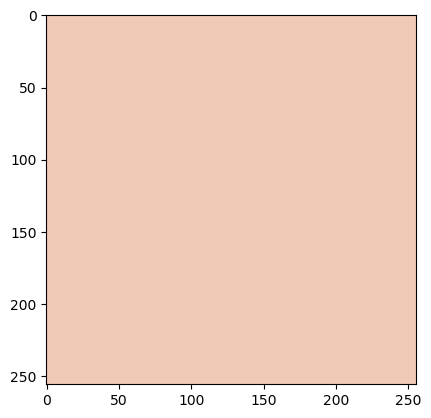

In [21]:
score = 0.6
raw_block = np.ones([256, 256])
img_heatmap = cmap(raw_block*score)[:,:,:3]
plt.imshow(img_heatmap)
plt.savefig("1.png")

Overlap heatmaps

In [1]:
from itertools import product

In [6]:
w, h = 1200, 1600
d = 256
overlap = 0.75

In [12]:
a = range(0, h-h%d, d)
b = range(0, w-w%d, d)
print(a)
print(b)

range(0, 1536, 256)
range(0, 1024, 256)


In [13]:
for i in a:
    print(i)

0
256
512
768
1024
1280


In [14]:
step = int(d*(1-overlap))
print(step)

64


In [15]:
# h -= d
# w -= d
grid = product(range(0, h-h%d-d+1, step), range(0, w-w%d-d+1, step))
for q in grid:
    print(q)

(0, 0)
(0, 64)
(0, 128)
(0, 192)
(0, 256)
(0, 320)
(0, 384)
(0, 448)
(0, 512)
(0, 576)
(0, 640)
(0, 704)
(0, 768)
(64, 0)
(64, 64)
(64, 128)
(64, 192)
(64, 256)
(64, 320)
(64, 384)
(64, 448)
(64, 512)
(64, 576)
(64, 640)
(64, 704)
(64, 768)
(128, 0)
(128, 64)
(128, 128)
(128, 192)
(128, 256)
(128, 320)
(128, 384)
(128, 448)
(128, 512)
(128, 576)
(128, 640)
(128, 704)
(128, 768)
(192, 0)
(192, 64)
(192, 128)
(192, 192)
(192, 256)
(192, 320)
(192, 384)
(192, 448)
(192, 512)
(192, 576)
(192, 640)
(192, 704)
(192, 768)
(256, 0)
(256, 64)
(256, 128)
(256, 192)
(256, 256)
(256, 320)
(256, 384)
(256, 448)
(256, 512)
(256, 576)
(256, 640)
(256, 704)
(256, 768)
(320, 0)
(320, 64)
(320, 128)
(320, 192)
(320, 256)
(320, 320)
(320, 384)
(320, 448)
(320, 512)
(320, 576)
(320, 640)
(320, 704)
(320, 768)
(384, 0)
(384, 64)
(384, 128)
(384, 192)
(384, 256)
(384, 320)
(384, 384)
(384, 448)
(384, 512)
(384, 576)
(384, 640)
(384, 704)
(384, 768)
(448, 0)
(448, 64)
(448, 128)
(448, 192)
(448, 256)
(448, 3

splits, val=test error

In [56]:
import pandas as pd

In [57]:
def df_prep(data, label_dict, ignore, label_col):
    if label_col != 'label':
        data['label'] = data[label_col].copy()

    mask = data['label'].isin(ignore)
    data = data[~mask]
    data.reset_index(drop=True, inplace=True)
    for i in data.index:
        key = data.loc[i, 'label']
        data.at[i, 'label'] = label_dict[key]

    return data

def filter_df(df, filter_dict={}):
    if len(filter_dict) > 0:
        filter_mask = np.full(len(df), True, bool)
        # assert 'label' not in filter_dict.keys()
        for key, val in filter_dict.items():
            mask = df[key].isin(val)
            filter_mask = np.logical_and(filter_mask, mask)
        df = df[filter_mask]
    return df

In [58]:
csv_path = "experiments/dataset_csv/fungal_vs_nonfungal.csv"
slide_data = pd.read_csv(csv_path)
filter_dict = {}
slide_data = filter_df(slide_data, filter_dict)
label_dict={'nonfungal': 0, 'fungal': 1}
label_col = 'label'
ignore=[]
slide_data = df_prep(slide_data, label_dict, ignore, label_col)
print(slide_data)

      case_id  slide_id label
0      case_0   F005a02     1
1      case_1   F006a01     1
2      case_2   F006a02     1
3      case_3   F006a03     1
4      case_4   F006a04     1
..        ...       ...   ...
418  case_418  N012a017     0
419  case_419  N012a018     0
420  case_420  N012a019     0
421  case_421  N012a020     0
422  case_422  N017a001     0

[423 rows x 3 columns]


In [59]:
csv_path = "experiments/splits/fungal_vs_nonfungal_100/splits_0.csv"
all_splits = pd.read_csv(csv_path, dtype='str')
print(all_splits)

    Unnamed: 0     train  annot       val      test
0            0  N001a001  False  N004a104  N012a012
1            1  N001a002  False  N012a014  N005a004
2            2  N003a001  False  N004a102  N004a012
3            3  N003a002  False  N004a103  N012a015
4            4  N004a005  False  N004a047  N004a070
..         ...       ...    ...       ...       ...
292        292   F030a06   True       NaN       NaN
293        293   F030a07   True       NaN       NaN
294        294   F030a08   True       NaN       NaN
295        295   F030a10   True       NaN       NaN
296        296   F030a11   True       NaN       NaN

[297 rows x 5 columns]


In [60]:
train_split = all_splits['train']
annot_split = all_splits['annot']

print(train_split)
print("="*50)
print(annot_split)

0      N001a001
1      N001a002
2      N003a001
3      N003a002
4      N004a005
         ...   
292     F030a06
293     F030a07
294     F030a08
295     F030a10
296     F030a11
Name: train, Length: 297, dtype: object
0      False
1      False
2      False
3      False
4      False
       ...  
292     True
293     True
294     True
295     True
296     True
Name: annot, Length: 297, dtype: object


In [55]:
# get_split_from_df
split_key = 'val'
split = all_splits[split_key]
split = split.dropna().reset_index(drop=True)

if len(split) > 0:
    mask = slide_data['slide_id'].isin(split.tolist())
    df_slice = slide_data[mask].reset_index(drop=True)
    print(df_slice)
#     split = Generic_Split(df_slice, data_dir=self.data_dir, annot_dir=self.annot_dir, num_classes=self.num_classes)
else:
    split = None

     case_id  slide_id label
0    case_10   F006a10     1
1    case_11   F007a01     1
2    case_13   F007a03     1
3    case_19   F007a09     1
4    case_20   F007a10     1
..       ...       ...   ...
58  case_369  N005a020     0
59  case_377  N006a006     0
60  case_389  N009a004     0
61  case_408  N012a007     0
62  case_415  N012a014     0

[63 rows x 3 columns]


In [61]:
# get_overlap_split_from_df
if len(train_split) > 0:
    mask = slide_data['slide_id'].isin(train_split)
    df_slice = slide_data[mask].reset_index(drop=True)

    mask = train_split.isin(df_slice['slide_id'].tolist())
    df_slice['annot'] = annot_split[mask]
    
    print(df_slice)

#     split = Generic_Split(df_slice, data_dir=self.data_dir, annot_dir=self.annot_dir, num_classes=self.num_classes)
else:
    split = None

      case_id  slide_id label  annot
0      case_0   F005a02     1  False
1      case_1   F006a01     1  False
2      case_3   F006a03     1  False
3      case_4   F006a04     1  False
4      case_5   F006a05     1  False
..        ...       ...   ...    ...
292  case_417  N012a016     0   True
293  case_418  N012a017     0   True
294  case_420  N012a019     0   True
295  case_421  N012a020     0   True
296  case_422  N017a001     0   True

[297 rows x 4 columns]


tensor bool

In [62]:
import torch

In [66]:
a = torch.Tensor([1])
print(bool(a))

True


Check .pkl

In [1]:
import os
from modules.file_utils import load_pkl

In [2]:
annot_dir = "experiments/annotations/patches/tile_annotations_overlap/"
slide_id = "F030a08"

In [3]:
patch_annot_path = os.path.join(annot_dir, slide_id, slide_id+'.pkl')
patch_annot = load_pkl(patch_annot_path)
# patch_annot = patch_annot['bin_scores']

In [4]:
patch_annot

{'patch_scores': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  459,
  459,
  0,
  0,
  0,
  0,
  0,
  0,
  1248,
  3285,
  4050,
  4905,
  3186,
  339,
  1980,
  1935,
  0,
  0],
 'bin_scores': [False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,

get_alpha_weight

In [1]:
def get_alpha_weight(epoch, T1, T2, af, correction):
    is_correction = not (epoch % correction)

    if is_correction or (epoch < T1):
        sup = 1.0
        unsup = 0.0
    elif epoch > T2:
        sup = 0.0
        unsup = af
    else:
        sup = 1.0
        unsup = ((epoch-T1) / (T2-T1))*af

    return sup, unsup


In [26]:
get_alpha_weight(75, 50, 150, 1, 10)

(1.0, 0.25)

check heatmap_dict

In [5]:
import pickle
import os

In [7]:
results_dir = 'experiments/results'
exp_code = 'exp_130_s1'
split = 4

In [8]:
def load_pkl(filename):
	loader = open(filename,'rb')
	file = pickle.load(loader)
	loader.close()
	return file

In [10]:
# heatmap_dict_1 = load_pkl(os.path.join(results_dir, exp_code, "splits_"+str(split), "heatmap_dict_1.pkl"))
heatmap_dict_2 = load_pkl(os.path.join(results_dir, exp_code, "splits_"+str(split), "heatmap_dict.pkl"))

In [11]:
heatmap_dict_1

NameError: name 'heatmap_dict_1' is not defined

In [12]:
heatmap_dict_2

[{'filename': 'F005a02',
  'attention_scores': [array([[0.01318033],
          [0.0130082 ],
          [0.012176  ],
          [0.01142519],
          [0.01175218],
          [0.01294637],
          [0.01269477],
          [0.01271495],
          [0.01316509],
          [0.01320487],
          [0.01193787],
          [0.01410028],
          [0.01260974],
          [0.01364795],
          [0.01311078],
          [0.0128829 ],
          [0.01301411],
          [0.01369847],
          [0.01417435],
          [0.01365568],
          [0.0140442 ],
          [0.01267878],
          [0.01454733],
          [0.01247958],
          [0.01322912],
          [0.01346042],
          [0.01295069],
          [0.01367122],
          [0.01301213],
          [0.01270596],
          [0.0127617 ],
          [0.01320234],
          [0.01384778],
          [0.01433385],
          [0.01345771],
          [0.0135001 ],
          [0.01283567],
          [0.01337724],
          [0.01257472],
          [0.012292

In [23]:
a = heatmap_dict_1 - heatmap_dict_2

In [25]:
sum(sum(a))

tensor(0., device='cuda:0')

Load model

In [12]:
from modules.model_clam import CLAM_MB, CLAM_SB
import torch
import os

In [13]:
results_dir = 'experiments/results'
exp_code = 'exp_62_s1'
split = 4

In [14]:
def print_network(net):
    num_params = 0
    num_params_train = 0
    print(net)

    for param in net.parameters():
        n = param.numel()
        num_params += n
        if param.requires_grad:
            num_params_train += n

    print('Total number of parameters: %d' % num_params)
    print('Total number of trainable parameters: %d' % num_params_train)

In [15]:
# Load model
model_dict = {"dropout": False, 'n_classes': 2}

model_size = 'small'
model_type = 'clam_sb'
if model_size is not None and model_type in ['clam_sb', 'clam_mb']:
    model_dict.update({"size_arg": model_size})

if model_type =='clam_sb':
    model = CLAM_SB(**model_dict)
elif model_type =='clam_mb':
    model = CLAM_MB(**model_dict)
else: # model_type == 'mil'
    if n_classes > 2:
        model = MIL_fc_mc(**model_dict)
    else:
        model = MIL_fc(**model_dict)

print_network(model)

CLAM_SB(
  (attention_net): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Attn_Net_Gated(
      (attention_a): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): Tanh()
      )
      (attention_b): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): Sigmoid()
      )
      (attention_c): Linear(in_features=256, out_features=1, bias=True)
    )
  )
  (classifiers): Linear(in_features=512, out_features=2, bias=True)
  (instance_classifier): Linear(in_features=512, out_features=2, bias=True)
  (instance_loss_fn): CrossEntropyLoss()
)
Total number of parameters: 789765
Total number of trainable parameters: 789765


In [16]:
ckpt_path = "s_4_checkpoint.pt"
ckpt_path = os.path.join(results_dir, exp_code, "splits_4", ckpt_path)

ckpt = torch.load(ckpt_path)
ckpt_clean = {}
for key in ckpt.keys():
    if 'instance_loss_fn' in key:
        continue
    ckpt_clean.update({key.replace('.module', ''):ckpt[key]})
model.load_state_dict(ckpt_clean, strict=False)

model.relocate()
model.eval()

CLAM_SB(
  (attention_net): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Attn_Net_Gated(
      (attention_a): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): Tanh()
      )
      (attention_b): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): Sigmoid()
      )
      (attention_c): Linear(in_features=256, out_features=1, bias=True)
    )
  )
  (classifiers): Linear(in_features=512, out_features=2, bias=True)
  (instance_classifier): Linear(in_features=512, out_features=2, bias=True)
  (instance_loss_fn): CrossEntropyLoss()
)

In [17]:
ckpt.keys()

odict_keys(['attention_net.0.weight', 'attention_net.0.bias', 'attention_net.3.attention_a.0.weight', 'attention_net.3.attention_a.0.bias', 'attention_net.3.attention_b.0.weight', 'attention_net.3.attention_b.0.bias', 'attention_net.3.attention_c.weight', 'attention_net.3.attention_c.bias', 'classifiers.weight', 'classifiers.bias', 'instance_classifier.weight', 'instance_classifier.bias', 'instance_loss_fn.labels'])

In [18]:
model.state_dict().keys()

odict_keys(['attention_net.0.weight', 'attention_net.0.bias', 'attention_net.2.attention_a.0.weight', 'attention_net.2.attention_a.0.bias', 'attention_net.2.attention_b.0.weight', 'attention_net.2.attention_b.0.bias', 'attention_net.2.attention_c.weight', 'attention_net.2.attention_c.bias', 'classifiers.weight', 'classifiers.bias', 'instance_classifier.weight', 'instance_classifier.bias'])

In [19]:
for key in model.state_dict().keys():
    print(key)
    new_key = key.replace("2", "3")
    model.state_dict()[new_key] = model.state_dict().pop(key)
    print(new_key)

attention_net.0.weight
attention_net.0.weight
attention_net.0.bias
attention_net.0.bias
attention_net.2.attention_a.0.weight
attention_net.3.attention_a.0.weight
attention_net.2.attention_a.0.bias
attention_net.3.attention_a.0.bias
attention_net.2.attention_b.0.weight
attention_net.3.attention_b.0.weight
attention_net.2.attention_b.0.bias
attention_net.3.attention_b.0.bias
attention_net.2.attention_c.weight
attention_net.3.attention_c.weight
attention_net.2.attention_c.bias
attention_net.3.attention_c.bias
classifiers.weight
classifiers.weight
classifiers.bias
classifiers.bias
instance_classifier.weight
instance_classifier.weight
instance_classifier.bias
instance_classifier.bias


In [52]:
model.state_dict()

OrderedDict([('attention_net.0.weight',
              tensor([[-5.7165e-06,  5.4982e-40, -4.0461e-05,  ..., -1.8883e-04,
                       -1.3762e-40,  1.9575e-40],
                      [ 4.8770e-02,  2.7350e-40,  1.9595e-02,  ...,  3.5833e-02,
                       -3.4447e-40, -4.4370e-40],
                      [ 1.3888e-03,  1.5224e-40, -4.5722e-02,  ..., -9.2081e-03,
                       -1.5423e-40,  1.6187e-40],
                      ...,
                      [-1.0319e-02,  1.4735e-40, -3.4660e-02,  ...,  5.5662e-02,
                       -6.2261e-40,  5.2500e-40],
                      [ 6.2526e-40, -3.2726e-40, -6.3352e-40,  ..., -1.0467e-26,
                       -4.4747e-40, -1.9231e-40],
                      [-5.6615e-40, -4.6335e-40,  6.3864e-40,  ..., -3.8538e-19,
                       -1.2296e-40, -1.0817e-40]], device='cuda:0')),
             ('attention_net.0.bias',
              tensor([-2.8845e-05, -5.5112e-03,  2.3322e-03, -1.8285e-03, -5.6718e-08,
  

In [26]:
for key in list(model.state_dict().keys()):
    model.state_dict()[key.replace("2", "3")] = model.state_dict().pop(key)

In [22]:
model.state_dict().keys()

odict_keys(['attention_net.0.weight', 'attention_net.0.bias', 'attention_net.2.attention_a.0.weight', 'attention_net.2.attention_a.0.bias', 'attention_net.2.attention_b.0.weight', 'attention_net.2.attention_b.0.bias', 'attention_net.2.attention_c.weight', 'attention_net.2.attention_c.bias', 'classifiers.weight', 'classifiers.bias', 'instance_classifier.weight', 'instance_classifier.bias'])

In [69]:
a = {}
for key in model.state_dict().keys():
    if "2" in key:
        new_key = key.replace("2", "3")
    a[new_key] = model.state_dict().pop(key)

In [70]:
a.keys()

dict_keys(['attention_net.3.attention_c.bias', 'attention_net.3.attention_a.0.weight', 'attention_net.3.attention_a.0.bias', 'attention_net.3.attention_b.0.weight', 'attention_net.3.attention_b.0.bias', 'attention_net.3.attention_c.weight'])

In [71]:
a

{'attention_net.3.attention_c.bias': tensor([ 0.0188, -0.0188], device='cuda:0'),
 'attention_net.3.attention_a.0.weight': tensor([[-0.0077,  0.0350, -0.0466,  ..., -0.0646,  0.0355,  0.0315],
         [-0.0719, -0.0400,  0.0255,  ...,  0.0659,  0.0317, -0.0447],
         [ 0.0412, -0.0449, -0.0629,  ...,  0.0338, -0.0354,  0.0065],
         ...,
         [ 0.0399, -0.0207, -0.0428,  ..., -0.0345, -0.0355,  0.0827],
         [-0.0841, -0.0283, -0.1021,  ..., -0.0051, -0.1022,  0.0061],
         [-0.0416,  0.0417, -0.0278,  ..., -0.0459,  0.0378, -0.0085]],
        device='cuda:0'),
 'attention_net.3.attention_a.0.bias': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

Loss

In [3]:
import torch
import torch.nn as nn

In [4]:
m = nn.Sigmoid()
loss = nn.BCELoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
output = loss(m(input), target)
output.backward()

In [5]:
input

tensor([-0.6004, -1.0813, -1.1827], requires_grad=True)

In [6]:
target

tensor([0., 1., 0.])

In [8]:
(m(input))

tensor([0.3543, 0.2533, 0.2346], grad_fn=<SigmoidBackward>)

Augmentations

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(1)

In [3]:
a = np.random.randint(0, 6, size=(1, 10))
print(a)

[[5 3 4 0 1 3 5 0 0 1]]


([array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])],
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Lists of Patches objects>)

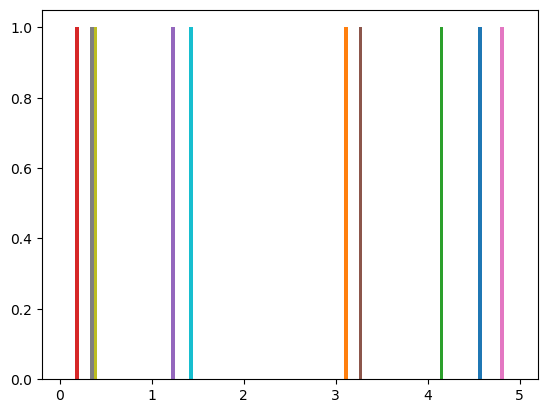

In [4]:
plt.hist(a)

In [5]:
b = np.histogram(a, range(7))
print(a)
print(b)

[[5 3 4 0 1 3 5 0 0 1]]
(array([3, 2, 0, 2, 1, 2]), array([0, 1, 2, 3, 4, 5, 6]))


Check acc.pkl

In [2]:
import pickle
import os

In [3]:
def load_pkl(filename):
	loader = open(filename,'rb')
	file = pickle.load(loader)
	loader.close()
	return file

In [17]:
acc_dict_path = os.path.join("experiments/results/exp_105_s1/splits_4", "acc_dict.pkl")

In [18]:
acc_dict = load_pkl(acc_dict_path)

In [19]:
acc_dict[-1]

{'avg_positive_acc_sc': 0.5123586091328027,
 'avg_positive_f1_sc': 0.4700310316807402}

Overlay scores on heatmaps (with overlaps)

In [261]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
from itertools import product
import cv2

In [262]:
img_path = os.path.abspath("experiments/annotations/original/F005a02.tif")
heatmap_mask = cv2.imread(img_path)
patch_size = [256, 256]
overlap = 0.5
w, h = 1536, 1024

In [263]:
d = patch_size[0]
step = int(d*(1-overlap))
grid = product(range(0, h-h%d-d+1, step), range(0, w-w%d-d+1, step))
# print(*grid)

In [264]:
percentiles = np.random.rand(77)
scores = np.random.rand(77)

In [265]:
plt.clf()
index = 0
for x, y in grid:
    print(y, x)
    print("__")
    plt.text(y, x, "a")
    # plt.text(int(y+0.00*patch_size[1]), int(x+0.00*patch_size[0]), str(round(percentiles[index], 4))+"\n"+str(round(scores[index], 4)), fontsize='x-small')
    index += 1

0 0
__
128 0
__
256 0
__
384 0
__
512 0
__
640 0
__
768 0
__
896 0
__
1024 0
__
1152 0
__
1280 0
__
0 128
__
128 128
__
256 128
__
384 128
__
512 128
__
640 128
__
768 128
__
896 128
__
1024 128
__
1152 128
__
1280 128
__
0 256
__
128 256
__
256 256
__
384 256
__
512 256
__
640 256
__
768 256
__
896 256
__
1024 256
__
1152 256
__
1280 256
__
0 384
__
128 384
__
256 384
__
384 384
__
512 384
__
640 384
__
768 384
__
896 384
__
1024 384
__
1152 384
__
1280 384
__
0 512
__
128 512
__
256 512
__
384 512
__
512 512
__
640 512
__
768 512
__
896 512
__
1024 512
__
1152 512
__
1280 512
__
0 640
__
128 640
__
256 640
__
384 640
__
512 640
__
640 640
__
768 640
__
896 640
__
1024 640
__
1152 640
__
1280 640
__
0 768
__
128 768
__
256 768
__
384 768
__
512 768
__
640 768
__
768 768
__
896 768
__
1024 768
__
1152 768
__
1280 768
__


ValueError: Image size of 634940x283907 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

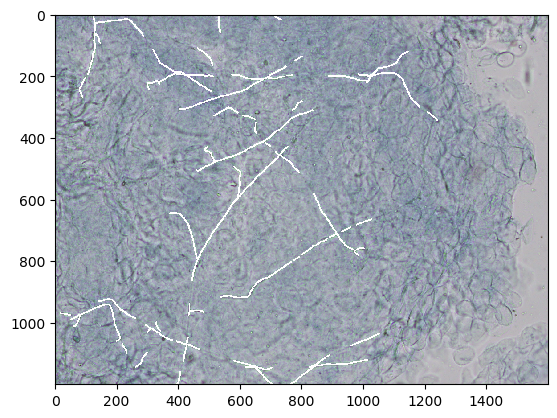

In [260]:
plt.imshow(heatmap_mask)

gt .pkl; MS_CLAM

In [44]:
import os
import argparse
import yaml
import numpy as np
from modules.file_utils import save_pkl, load_pkl

In [45]:
patch_dir = "experiments/annotations/patches/tile_annotations_overlap/"
output_patches_dir = "experiments/ms_clam/"

In [46]:
for filename in os.listdir(source_dir):
    name, ext = os.path.splitext(filename)
    if "N" in name:
        continue
    get_path = os.path.join(patch_dir, name, name+".pkl")
    scores = load_pkl(get_path)
    bin_scores = scores['bin_scores']

    indexes = np.where(bin_scores)
    save_object = list(indexes[0])
    save_path = os.path.join(output_patches_dir, name+".pkl")
    save_pkl(save_path, save_object)


# Heatmaps

In [10]:
from PIL import Image
import torch
import os
import shutil
import yaml
import argparse
import numpy as np
import pickle
from itertools import product
from modules.utils import *
from modules.file_utils import save_pkl, load_pkl
from modules.resnet_custom import resnet50_baseline
from modules.model_clam import CLAM_MB, CLAM_SB
from torch.utils.data import DataLoader
from scipy.stats import percentileofscore
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage.color import label2rgb
import cv2 as cv
import pandas as pd
from sklearn.metrics import accuracy_score

In [12]:
def score2percentile(score, ref):
    percentile = percentileofscore(ref, score)
    return percentile

In [16]:
def compute_from_patches_overlap(clam_pred=None, model=None, feature_extractor=None, batch_size=512,
    attn_save_path=None, ref_scores=None, feat_save_path=None, test_split=None):

    heatmap_dict = []

    if only_test_split:
        select_image = test_split

    # Load the dataset
    # Create dataset from the image patches
    for index, image_file in enumerate(sorted(os.listdir(data_dir))):
        # if index not in select_image:
        #     continue
        filename, ext = os.path.splitext(image_file)
        if filename not in select_image:
            continue
        img = Image.open(os.path.join(data_dir, image_file))
        w, h = img.size
        d = patch_size[0]

        dataset = []
        count = 0
        step = int(d*(1-overlap))
        grid = product(range(0, h-h%d-d+1, step), range(0, w-w%d-d+1, step))
        for i, j in grid:
            box = (j, i, j+d, i+d)
            count += 1
            patch = img.crop(box)
            patch_arr = np.asarray(patch)
            # img_arr = np.expand_dims(img_arr, 0)
            # img_PIL = Image.fromarray(img_arr)

            # Create the dataset loader
            patch_tensor = torch.tensor(patch_arr)

            # Get coord in [x, y] format
            coord = [int(i), int(j)]

            dataset.append([patch_tensor, coord])

        roi_loader = DataLoader(dataset=dataset, batch_size=count)
        print("File:", filename)

        num_batches = len(roi_loader)
        print('number of batches: ', len(roi_loader)) # len(roi_loader) = count / (batch_size)
        mode = "w"

        attention_scores = []
        coords_list = []

        for idx, (roi, coords) in enumerate(roi_loader):
            roi = roi.to(device)

            with torch.no_grad():
                roi = roi.reshape([count, 3, patch_size[0], patch_size[1]])
                roi = roi.float()
                features = feature_extractor(roi)

                if attn_save_path is not None:
                    A = model(features, attention_only=True)
                    A = F.softmax(A, dim=1)  # softmax over N

                    if A.size(0) > 1: #CLAM multi-branch attention
                        if clam_pred:
                            A = A[clam_pred]

                    A = A.view(-1, 1).cpu().numpy()

                    if ref_scores is not None:
                        for score_idx in range(len(A)):
                            A[score_idx] = score2percentile(A[score_idx], ref_scores)

                    # Save
                    attention_scores.append(A)
                    coords_list.append(coords)

            # if idx % math.ceil(num_batches * 0.05) == 0:
            #     print('procssed {} / {}'.format(idx, num_batches))

            if feat_save_path is not None:
                asset_dict = {'features': features.cpu().numpy(), 'coords': coords}
                # Save # TBD. Not required

            heatmap_dict.append({"filename": filename, "attention_scores": attention_scores, "coords_list": coords_list})

            mode = "a"
    return heatmap_dict


In [17]:
def draw_heatmaps_overlap(exp_code, cmap='coolwarm'):
    """
    Plot and save the heatmaps. Overlap method.
    """
    for split in splits:
        ckpt_path = "s_"+str(split)+"_checkpoint.pt"
        save_path = os.path.join(results_dir, exp_code, "splits_"+str(split), "heatmaps")
        if delete_previous:
            shutil.rmtree(save_path)
        if not os.path.isdir(save_path):
            os.mkdir(save_path)

        patch_accuracies = {}
        heatmap_dict = load_pkl(os.path.join(results_dir, exp_code, "splits_"+str(split), "heatmap_dict.pkl"))

        for image_file in heatmap_dict:
            image_name = image_file['filename']
            attention_scores = image_file['attention_scores']
            coords_list = image_file['coords_list']
            # print(coords_list)

            plt.clf()
            if isinstance(cmap, str):
                cmap = plt.get_cmap(cmap)

            img_path = os.path.join(data_dir, image_name+image_ext)
            # orig_img = np.array(Image.open(img_path))
            # orig_img = orig_img[0:1024, 0:1536] # No left-overs

            orig_img = cv.imread(img_path)
            orig_img = orig_img[0:1024, 0:1536] # No left-overs

            scores = attention_scores[0].copy()
            scores = [float(x) for x in scores]
            percentiles = []
            for score in scores:
                percentile = percentileofscore(scores, score)
                percentiles.append(percentile/100)
            # print(scores)
            # print()
            # print(percentiles)

            patch_annot_path = os.path.join(annot_dir, image_name, image_name+'.pkl')
            patch_annot = load_pkl(patch_annot_path)
            patch_annot = patch_annot['bin_scores']

            preds = [1 if x >= 0.5 else 0 for x in percentiles]
            acc = accuracy_score(patch_annot, preds)
            patch_accuracies.update({'filename': image_name, 'accuracy_score': acc})

            heatmap_mask = np.zeros([1024, 1536, 3])
            counter = np.zeros([1024, 1536, 3])

            for index, block_score in enumerate(percentiles):
                x = coords_list[0][0][index].item() # Top left corner
                y = coords_list[0][1][index].item() # Top left corner
                # print("Score, x, y:", block_score, x, y)
                # print(x, y, x+patch_size[0], y+patch_size[1])

                raw_block = np.ones([patch_size[0], patch_size[1]])
                color_block = cmap(raw_block*block_score)[:,:,:3]
                heatmap_mask[x:x+patch_size[0], y:y+patch_size[1], :] += color_block.copy()
                counter[x:x+patch_size[0], y:y+patch_size[1], :] += 1

                if show_labels:
                    plt.text(y+0.25*patch_size[1], x+0.25*patch_size[0], str(round(percentiles[index], 4))+"\n"+str(round(scores[index], 4)), fontsize='x-small')
            # print(heatmap_mask.shape)

            # Average
            zero_mask = counter == 0
            heatmap_mask[~zero_mask] = heatmap_mask[~zero_mask] / counter[~zero_mask]
            del counter

            # Normalise
            eps = 1e-8
            numer = heatmap_mask - np.min(heatmap_mask)
            denom = (heatmap_mask.max() - heatmap_mask.min()) + eps
            heatmap_mask = numer / denom
            heatmap_mask = cv.blur(heatmap_mask, tuple(blur))

            img_heatmap_filename = os.path.join(save_path, image_name+"_heatmap"+".png")

            orig_img = orig_img.astype(np.float32)
            orig_img /= 255.0

            alpha = 0.6
            beta = 0.4
            gamma = 0.0
            eps = 1e-8

            img_heatmap = cv.addWeighted(orig_img, alpha, heatmap_mask, beta, gamma, dtype=cv.CV_64F)
            # img_heatmap = orig_img.copy()

            # Normalise
            numer = img_heatmap - np.min(img_heatmap)
            denom = (img_heatmap.max() - img_heatmap.min()) + eps
            img_heatmap = numer / denom

            plt.imshow(img_heatmap)
            plt.savefig(img_heatmap_filename)
            print("Saved", img_heatmap_filename)
        print()

        acc_dict_save = os.path.join(results_dir, exp_code, "splits_"+str(split), "acc_dict.pkl")
        save_pkl(acc_dict_save, patch_accuracies)



In [18]:
def generate_heatmap_dict(exp_code, use_overlap=True):
    """
    Run saved model on select images for generating heatmap info.
    """
    feature_extractor = resnet50_baseline(pretrained=True)
    feature_extractor.eval()
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if torch.cuda.device_count() > 1:
        device_ids = list(range(torch.cuda.device_count()))
        feature_extractor = nn.DataParallel(feature_extractor, device_ids=device_ids).to('cuda:0')
    else:
        feature_extractor = feature_extractor.to(device)
    feature_extractor.eval()

    # Load model
    model_dict = {"dropout": drop_out, 'n_classes': n_classes}

    if model_size is not None and model_type in ['clam_sb', 'clam_mb']:
        model_dict.update({"size_arg": model_size})

    if model_type =='clam_sb':
        model = CLAM_SB(**model_dict)
    elif model_type =='clam_mb':
        model = CLAM_MB(**model_dict)
    else: # model_type == 'mil'
        if n_classes > 2:
            model = MIL_fc_mc(**model_dict)
        else:
            model = MIL_fc(**model_dict)

    print_network(model)

    for split in splits:
        print("Evaluating attentions scores for split_{}".format(split))

        save_path = os.path.join(results_dir, exp_code, "splits_"+str(split), "heatmaps")
        if not os.path.isdir(save_path):
            os.mkdir(save_path)
        ref_scores = None
        Y_hats = None
        ckpt_path = "s_"+str(split)+"_checkpoint.pt"
        ckpt_path = os.path.join(results_dir, exp_code, "splits_"+str(split), ckpt_path)

        ckpt = torch.load(ckpt_path)
        ckpt_clean = {}
        for key in ckpt.keys():
            if 'instance_loss_fn' in key:
                continue
            ckpt_clean.update({key.replace('.module', ''):ckpt[key]})

        # Replace 3 with 2.
        ckpt_clean_2 = {}
        for key, value in ckpt_clean.items():
            new_key = key.replace("3", "2") if "3" in key else key
            ckpt_clean_2[new_key] = value
        model.load_state_dict(ckpt_clean_2, strict=True)

        model.relocate()
        model.eval()

        if only_test_split:
            csv_path = '{}/splits_{}.csv'.format(split_dir, split)
            df = pd.read_csv(csv_path)
            test_split = df[df['test'].notnull()]['test']
            test_split = list(test_split)
        else:
            test_split = None

        if use_overlap:
            heatmap_dict = compute_from_patches_overlap(model=model, feature_extractor=feature_extractor, batch_size=512, attn_save_path=save_path, ref_scores=ref_scores, test_split=test_split)
        else:
            heatmap_dict = compute_from_patches(model=model, feature_extractor=feature_extractor, batch_size=512, attn_save_path=save_path,  ref_scores=ref_scores)

        heatmap_dict_save = os.path.join(results_dir, exp_code, "splits_"+str(split), "heatmap_dict.pkl")
        save_pkl(heatmap_dict_save, heatmap_dict)
        print()

    print("Done!")


In [28]:
heatmap_dict_only = False
alpha = 1
annot_dir = "experiments/annotations/patches/tile_annotations_overlap/"
beta = 0.5
blur = [128, 128]
cmap = "coolwarm"
data_dir = "experiments/annotations/original/"
delete_previous = True
drop_out = False
exp_codes = ["exp_131_s1"]
feat_dir = "experiments/features/"
gamma = 0.0
get_patch_acc = False
image_ext = ".tif"
model_size = "small"
model_type = "clam_sb"
n_classes = 2
only_test_split = False
overlap = 0.5
patch_dir = "experiments/patches/"
patch_size = [256, 256]
results_dir = "experiments/results/" #_saved/results_8/
run_draw_heatmaps = True
run_heatmap_dict = True
select_image = ["F006a02"]
show_labels = False
split_dir = "experiments/splits/fungal_vs_nonfungal_100_af_98"
splits = [0]
threshold = 0.5
use_overlap = True


In [29]:
if use_overlap:
    for exp_code in exp_codes:
        generate_heatmap_dict(exp_code, use_overlap)
        if not heatmap_dict_only:
            draw_heatmaps_overlap(exp_code, cmap)
else:
    for exp_code in exp_codes:
        generate_heatmap_dict(exp_code)
        if not heatmap_dict_only:
            draw_heatmaps(exp_code, cmap)

CLAM_SB(
  (attention_net): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Attn_Net_Gated(
      (attention_a): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): Tanh()
      )
      (attention_b): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): Sigmoid()
      )
      (attention_c): Linear(in_features=256, out_features=1, bias=True)
    )
  )
  (classifiers): Linear(in_features=512, out_features=2, bias=True)
  (instance_classifier): Linear(in_features=512, out_features=2, bias=True)
  (instance_loss_fn): CrossEntropyLoss()
  (attention_loss_positive): L1Loss()
  (attention_loss_negative): L1Loss()
)
Total number of parameters: 789765
Total number of trainable parameters: 789765
Evaluating attentions scores for split_0


UnboundLocalError: local variable 'select_image' referenced before assignment

Check heatmap_dict.pkl

In [96]:
import pickle
import os
import numpy as np
from scipy.stats import percentileofscore

In [97]:
results_dir = 'experiments/results'
exp_code = 'exp_131_s1'
split = 0

In [98]:
def score2percentile(score, ref):
    percentile = percentileofscore(ref, score)
    return percentile

In [99]:
def load_pkl(filename):
	loader = open(filename,'rb')
	file = pickle.load(loader)
	loader.close()
	return file

In [103]:
heatmap_dict = load_pkl(os.path.join(results_dir, exp_code, "splits_"+str(split), "heatmap_dict_saved.pkl"))

In [104]:
heatmap_dict

[{'filename': 'F006a02',
  'attention_scores': [array([[1.1544187 ],
          [1.1259992 ],
          [1.2127464 ],
          [1.3161151 ],
          [1.353647  ],
          [1.3213216 ],
          [1.13365   ],
          [1.091607  ],
          [1.1163468 ],
          [1.1241724 ],
          [1.1237589 ],
          [1.1525645 ],
          [1.2170122 ],
          [1.5331967 ],
          [1.6310544 ],
          [1.5956204 ],
          [1.560915  ],
          [1.3170593 ],
          [1.1022122 ],
          [1.0761796 ],
          [1.086942  ],
          [1.090826  ],
          [1.2654096 ],
          [1.3398256 ],
          [1.4738958 ],
          [1.5893347 ],
          [1.5351205 ],
          [1.4249246 ],
          [1.4526232 ],
          [1.1146215 ],
          [1.1126347 ],
          [1.1090772 ],
          [1.0893492 ],
          [1.184888  ],
          [0.98610604],
          [1.0955267 ],
          [1.0818366 ],
          [1.1465174 ],
          [1.2014138 ],
          [1.361411

In [474]:
attention_scores = heatmap_dict[1]['attention_scores'][0]
print(attention_scores)

[0.6 0.6 0.6 0.6 0.  0.7 0.  0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6
 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6
 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6
 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6
 0.6 0.6 0.6 0.6 0.6]


In [9]:
scores = attention_scores.copy()
scores = [float(x) for x in scores]
percentiles = []
for score in scores:
    percentile = percentileofscore(scores, score)
    percentiles.append(percentile/100)

In [10]:
percentiles

[0.6883116883116882,
 0.7012987012987013,
 0.5584415584415584,
 0.5844155844155844,
 0.9090909090909091,
 0.8961038961038961,
 0.6753246753246753,
 0.8571428571428571,
 0.37662337662337664,
 0.8181818181818181,
 0.2207792207792208,
 0.5194805194805194,
 0.6103896103896104,
 0.6493506493506493,
 0.7922077922077922,
 0.8051948051948052,
 0.1948051948051948,
 0.14285714285714288,
 0.41558441558441556,
 0.07792207792207792,
 0.03896103896103896,
 0.33766233766233766,
 0.5974025974025974,
 0.5454545454545454,
 0.7272727272727273,
 0.948051948051948,
 0.987012987012987,
 0.7402597402597402,
 0.24675324675324675,
 0.16883116883116883,
 0.4805194805194805,
 0.3116883116883117,
 0.012987012987012986,
 0.6623376623376623,
 0.6363636363636364,
 0.8441558441558442,
 1.0,
 0.4935064935064935,
 0.5324675324675324,
 0.2727272727272727,
 0.051948051948051945,
 0.025974025974025972,
 0.20779220779220778,
 0.4415584415584416,
 0.7142857142857143,
 0.7662337662337663,
 0.9740259740259741,
 0.935064935064

In [11]:
red = [percentile > 0.5 for percentile in percentiles]
print(red)

[True, True, True, True, True, True, True, True, False, True, False, True, True, True, True, True, False, False, False, False, False, False, True, True, True, True, True, True, False, False, False, False, False, True, True, True, True, False, True, False, False, False, False, False, True, True, True, True, True, False, False, False, False, False, False, True, True, True, False, False, True, True, False, True, True, False, True, True, False, False, False, False, False, False, False, False, False]


In [14]:
min_max = []
min_score = min(scores)
max_score = max(scores)
for score in scores:
    value = (score - min_score) / (max_score - min_score)
    min_max.append(value)

In [422]:
min_max

NameError: name 'min_max' is not defined

Write to .pkl

In [266]:
import pickle
import os
import torch
import numpy as np
from itertools import product
from scipy.stats import percentileofscore
from torch.utils.data import DataLoader
from modules.file_utils import save_pkl, load_pkl

In [267]:
results_dir = 'experiments/results'
exp_code = 'exp_131_s1'
split = 0
data_dir = 'experiments/annotations/original/'

heatmap_dict_file = os.path.join(results_dir, exp_code, "splits_"+str(split), "heatmap_dict.pkl")

In [268]:
heatmap_dict = []
filename = "F007a02"

In [269]:
w, h = 1600, 1200
d = 256
overlap = 0.5
step = int(d*(1-overlap))
grid = product(range(0, h-h%d-d+1, step), range(0, w-w%d-d+1, step))
coords_list = [[int(i), int(j)] for i, j in grid]

In [355]:
coords_list = [[torch.Tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 128, 128, 128,
            128, 128, 128, 128, 128, 128, 128, 128, 256, 256, 256, 256, 256, 256,
            256, 256, 256, 256, 256, 384, 384, 384, 384, 384, 384, 384, 384, 384,
            384, 384, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 640,
            640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 768, 768, 768, 768,
            768, 768, 768, 768, 768, 768, 768]),
    torch.Tensor([   0,  128,  256,  384,  512,  640,  768,  896, 1024, 1152, 1280,    0,
             128,  256,  384,  512,  640,  768,  896, 1024, 1152, 1280,    0,  128,
             256,  384,  512,  640,  768,  896, 1024, 1152, 1280,    0,  128,  256,
             384,  512,  640,  768,  896, 1024, 1152, 1280,    0,  128,  256,  384,
             512,  640,  768,  896, 1024, 1152, 1280,    0,  128,  256,  384,  512,
             640,  768,  896, 1024, 1152, 1280,    0,  128,  256,  384,  512,  640,
             768,  896, 1024, 1152, 1280])]]

In [356]:
# attention_scores = np.random.random(77)
att_scores = np.ones(77)

In [357]:
attention_scores = [[x] for x in att_scores]

In [358]:
heatmap_dict.append({"filename": filename, "attention_scores": attention_scores, "coords_list": coords_list})

In [359]:
def score2percentile(score, ref):
    percentile = percentileofscore(ref, score)
    return percentile

In [360]:
def load_pkl(filename):
	loader = open(filename,'rb')
	file = pickle.load(loader)
	loader.close()
	return file

In [361]:
def write2pkl(data, filename):
    with open(filename, 'wb') as f:
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [362]:
write2pkl(heatmap_dict, heatmap_dict_file)

In [363]:
load_heatmap_dict = load_pkl(heatmap_dict_file)

In [364]:
select_image = [
'F005a02',
'F006a01'
]

In [378]:
def run_heatmap(A):
    heatmap_dict = []
    for index, image_file in enumerate(sorted(os.listdir(data_dir))):
        filename, ext = os.path.splitext(image_file)

        if filename not in select_image:
            continue

        w, h = 1600, 1200
        d = 256
        overlap = 0.5

        dataset = []
        count = 0
        step = int(d*(1-overlap))
        grid = product(range(0, h-h%d-d+1, step), range(0, w-w%d-d+1, step))
        for i, j in grid:
            count += 1
            patch_tensor = torch.tensor(range(77))
            coord = [int(i), int(j)]
            dataset.append([patch_tensor, coord])

        roi_loader = DataLoader(dataset=dataset, batch_size=count)
        print("File:", filename)

        attention_scores = []
        coords_list = []

        for idx, (roi, coords) in enumerate(roi_loader):
            attention_scores.append(A)
            coords_list.append(coords)

            heatmap_dict.append({"filename": filename, "attention_scores": attention_scores, "coords_list": coords_list})

        heatmap_dict_save = os.path.join(results_dir, exp_code, "splits_"+str(split), "heatmap_dict.pkl")
        save_pkl(heatmap_dict_save, heatmap_dict)
    print("Done")

In [465]:
# A = np.random.random(77)

A = np.ones(77)
A = A * 0.6
A[5] = 0.7
A[6] = 0.1
A[4] = 0.2

# A = np.concatenate((np.zeros(38), np.ones(39)))

print(len(A), A)

77 [0.6 0.6 0.6 0.6 0.1 0.7 0.  0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6
 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6
 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6
 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6
 0.6 0.6 0.6 0.6 0.6]


In [466]:
run_heatmap(A)

File: F005a02
File: F006a01
Done


In [470]:
1/77

0.012987012987012988

In [473]:
percentileofscore(A, 0.0)

1.2987012987012987

cmap

In [448]:
import matplotlib.pyplot as plt

In [449]:
cmap = 'coolwarm'
cmap = plt.get_cmap(cmap)

In [450]:
block_score = 0.5
raw_block = np.ones([256, 256])
color_block = cmap(raw_block*block_score)[:,:,:3]

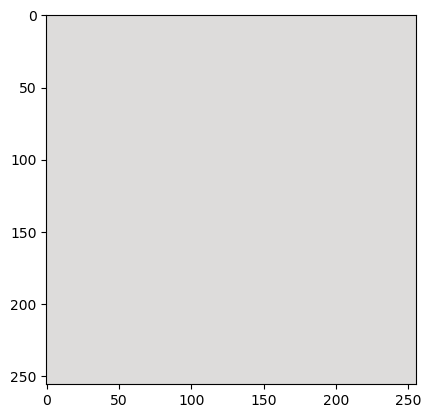

In [451]:
plt.imshow(color_block)

draw heatmaps

In [452]:
import cv2 as cv

In [453]:
cmap='coolwarm'
if isinstance(cmap, str):
    cmap = plt.get_cmap(cmap)

In [454]:
image_ext = '.tif'
patch_size = [256, 256]
save_path = os.path.join(results_dir, exp_code, "splits_"+str(split), "heatmaps")
heatmap_dict = load_pkl(os.path.join(results_dir, exp_code, "splits_"+str(split), "heatmap_dict.pkl"))

Saved experiments/results/exp_131_s1/splits_0/heatmaps/F005a02_heatmap.png
Saved experiments/results/exp_131_s1/splits_0/heatmaps/F006a01_heatmap.png



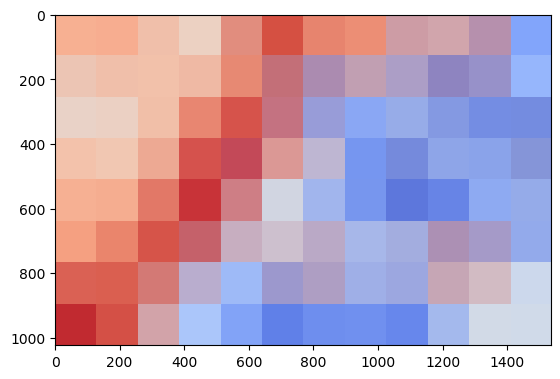

In [495]:
for image_file in heatmap_dict:
    image_name = image_file['filename']
    attention_scores = image_file['attention_scores']
    coords_list = image_file['coords_list']

    plt.clf()
    img_path = os.path.join(data_dir, image_name+image_ext)
    # orig_img = np.array(Image.open(img_path))
    # orig_img = orig_img[0:1024, 0:1536] # No left-overs

    orig_img = cv.imread(img_path)
    orig_img = orig_img[0:1024, 0:1536] # No left-overs

    scores = attention_scores[0].copy()
    scores = [float(x) for x in scores]
    percentiles = []
    for score in scores:
        percentile = percentileofscore(scores, score)
#         print(percentile)
        percentiles.append(percentile/100)
#     print(scores)
#     print(percentiles)

    heatmap_mask = np.zeros([1024, 1536, 3])
    counter = np.zeros([1024, 1536, 3])

    for index, block_score in enumerate(A):
        x = coords_list[0][0][index].item() # Top left corner
        y = coords_list[0][1][index].item() # Top left corner
        # print("Score, x, y:", block_score, x, y)
        # print(x, y, x+patch_size[0], y+patch_size[1])

        raw_block = np.ones([patch_size[0], patch_size[1]])
        color_block = cmap(raw_block*block_score)[:,:,:3]
        heatmap_mask[x:x+patch_size[0], y:y+patch_size[1], :] += color_block.copy()
        counter[x:x+patch_size[0], y:y+patch_size[1], :] += 1

    # Average
    zero_mask = counter == 0
    heatmap_mask[~zero_mask] = heatmap_mask[~zero_mask] / counter[~zero_mask]
    del counter

    # Normalise
    # eps = 1e-8
    # numer = heatmap_mask - np.min(heatmap_mask)
    # denom = (heatmap_mask.max() - heatmap_mask.min()) + eps
    # heatmap_mask = numer / denom
    # heatmap_mask = cv.blur(heatmap_mask, tuple(blur))

    img_heatmap_filename = os.path.join(save_path, image_name+"_heatmap"+".png")

    orig_img = orig_img.astype(np.float32)
    orig_img /= 255.0

    alpha = 0.75
    beta = 0.25
    gamma = 0.0
    eps = 1e-8

    blank = np.ones([1024, 1536, 3])
    # img_heatmap = cv.addWeighted(blank, alpha, heatmap_mask, beta, gamma, dtype=cv.CV_64F)
    img_heatmap = heatmap_mask.copy()
    # img_heatmap = orig_img.copy()

    # Normalise
#             numer = img_heatmap - np.min(img_heatmap)
#             denom = (img_heatmap.max() - img_heatmap.min()) + eps
#             img_heatmap = numer / denom

    plt.imshow(img_heatmap)
    plt.savefig(img_heatmap_filename)
    print("Saved", img_heatmap_filename)
print()

In [456]:
percentileofscore(scores, 1.000000000000001)

100.0

Test heatmap counter

In [404]:
w, h = 1600, 1200
d = 256
overlap = 0.5
step = int(d*(1-overlap))
grid = product(range(0, h-h%d-d+1, step), range(0, w-w%d-d+1, step))
coords_list = [[int(i), int(j)] for i, j in grid]

(4718592,)
(1024, 1536, 3)


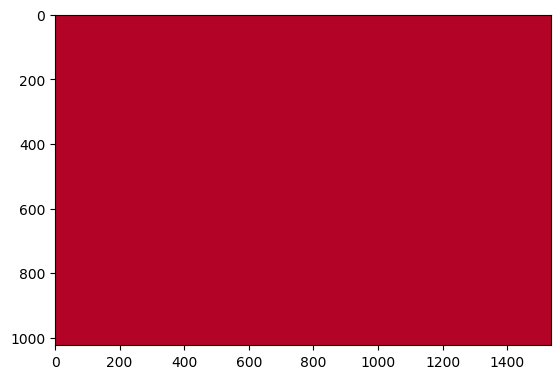

In [405]:
heatmap_mask = np.zeros([1024, 1536, 3])
counter = np.zeros([1024, 1536, 3])

block_scores = np.ones(77)

for index, block_score in enumerate(block_scores):
    x = coords_list[index][0] # Top left corner
    y = coords_list[index][1] # Top left corner
    # print(f"Score: {block_score},\t Coord: ({x}, {y})")
    # print(x, y, x+patch_size[0], y+patch_size[1])

    raw_block = np.ones([patch_size[0], patch_size[1]])
    color_block = cmap(raw_block*block_score)[:,:,:3]
    heatmap_mask[x:x+patch_size[0], y:y+patch_size[1], :] += color_block.copy()
    counter[x:x+patch_size[0], y:y+patch_size[1], :] += 1

# Average
zero_mask = counter == 0
print(counter[~zero_mask].shape)
heatmap_mask[~zero_mask] = heatmap_mask[~zero_mask] / counter[~zero_mask]
print(heatmap_mask.shape)

plt.imshow(heatmap_mask)

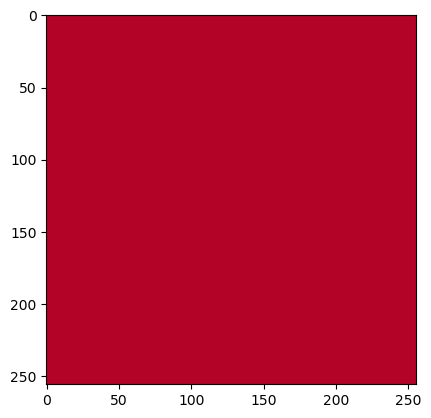

In [406]:
cmap = 'coolwarm'
cmap = plt.get_cmap(cmap)

block_score = 1
raw_block = np.ones([256, 256])
color_block = cmap(raw_block*block_score)[:,:,:3]

plt.imshow(color_block)

In [488]:
A = [[1.2102236 ], [1.2109854 ], [1.1987542 ], [1.2013814 ], [1.3798563 ], [1.3519098 ], [1.2076006 ], [1.3027649 ], [1.1411918 ], [1.2709674 ], [1.099219  ], [1.1967802 ], [1.2036636 ], [1.2058383 ], [1.2563491 ], [1.2565368 ], [1.0742013 ], [1.0448781 ], [1.1523196 ], [1.0003339 ], [0.94150054], [1.1256126 ], [1.202667  ], [1.1974709 ], [1.211803  ], [1.4002435 ], [1.4219555 ], [1.2313699 ], [1.1086246 ], [1.063884  ], [1.1830301 ], [1.1226819 ], [0.912435  ], [1.206051  ], [1.2052711 ], [1.2917991 ], [1.4694947 ], [1.1954663 ], [1.197309  ], [1.1125361 ], [0.99224657], [0.9353275 ], [1.0823883 ], [1.1526294 ], [1.2116649 ], [1.2377931 ], [1.4073925 ], [1.3997605 ], [1.1966243 ], [1.1256014 ], [1.0423479 ], [1.1193837 ], [0.99931276], [1.1102588 ], [1.0407897 ], [1.2335097 ], [1.3823143 ], [1.3234478 ], [1.12874   ], [1.1507983 ], [1.2525052 ], [1.199854  ], [1.126689  ], [1.2043185 ], [1.3121154 ], [1.1523677 ], [1.4024311 ], [1.286131  ], [1.1419541 ], [1.1155508 ], [1.0488814 ], [1.0328379 ], [1.1045365 ], [1.034923  ], [1.0677267 ], [1.177608  ], [1.1642177 ]]

In [489]:
B = []
max_a = max(A)
min_a = min(A)
for a in A:
    b = (a[0] - min_a[0]) / (max_a[0] - min_a[0])
    B.append(b)

In [490]:
A = B

In [492]:
B = []
for score in A:
    percentile = percentileofscore(A, score)
#         print(percentile)
    B.append(percentile/100)

In [493]:
A = B